<a href="https://colab.research.google.com/github/jejjohnson/gp_model_zoo/blob/master/code/numpyro/numpyro_sparsegp_uncertain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sparse Gaussian Process w/ Numpyro

My starting notebook where I install all of the necessary libraries and load some easy 1D/2D Regression data to play around with.

In [1]:
# #@title Install Packages
# %%capture
# !pip install pyprojroot jax jaxlib chex numpyro flax distrax numpy pandas seaborn matplotlib corner loguru nb_black sklearn

In [2]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".root"])

# append to path
sys.path.append(str(root))

In [3]:
# @title Load Packages
# TYPE HINTS
from typing import Tuple, Optional, Dict, Callable, Union

# JAX SETTINGS
import jax
import jax.numpy as jnp
import jax.random as random


# JAX UTILITY LIBRARIES
import chex

# NUMPYRO SETTINGS
import numpyro
import numpyro.distributions as dist
from numpyro.infer.autoguide import AutoDiagonalNormal
from numpyro.infer import SVI, Trace_ELBO

# NUMPY SETTINGS
import numpy as np

np.set_printoptions(precision=3, suppress=True)

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns

sns.set_context(context="talk", font_scale=0.7)

# PANDAS SETTINGS
import pandas as pd

pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

# LOGGING SETTINGS
import loguru

%load_ext lab_black
%load_ext autoreload
%autoreload 2

## Data

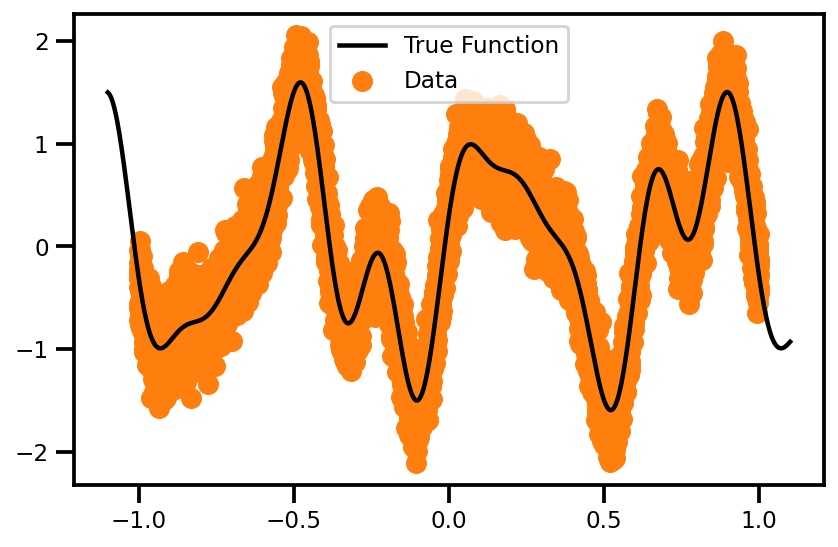

In [4]:
from src.data import regression_complex, regression_simple

Xtrain, ytrain, xtest, ytest = regression_complex(
    n_train=10_000, n_test=1_000, noise=0.2, seed=123, buffer=0.1
)

fig, ax = plt.subplots()
ax.scatter(Xtrain, ytrain, color="tab:orange", label="Data")
ax.plot(xtest, ytest, color="black", label="True Function")
ax.legend()
plt.tight_layout()
plt.show()

## Gaussian Process Model

### Kernel Function

In [5]:
from chex import Array
from src.utils import identity_matrix, add_to_diagonal
from src.kernels import RBF

In [6]:
rbf_kernel = RBF(length_scale=1.0, variance=1.0)
K = rbf_kernel.gram(Xtrain)

# check shape
chex.assert_shape(K, (Xtrain.shape[0], Xtrain.shape[0]))

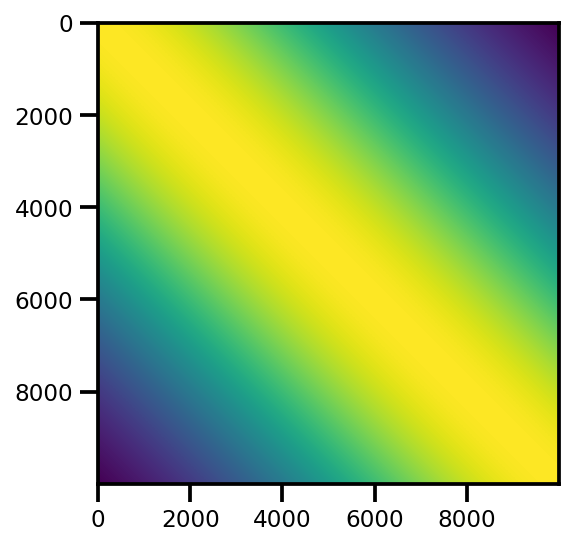

In [7]:
fig, ax = plt.subplots()

ax.imshow(K, interpolation="nearest")
plt.tight_layout()
plt.show()

### Inducing Points

In [8]:
n_inducing = 100

#### Random Selection

In [9]:
from src.utils import init_inducing_subsample, init_inducing_kmeans

X_u_init = init_inducing_subsample(Xtrain, n_inducing, seed=42)

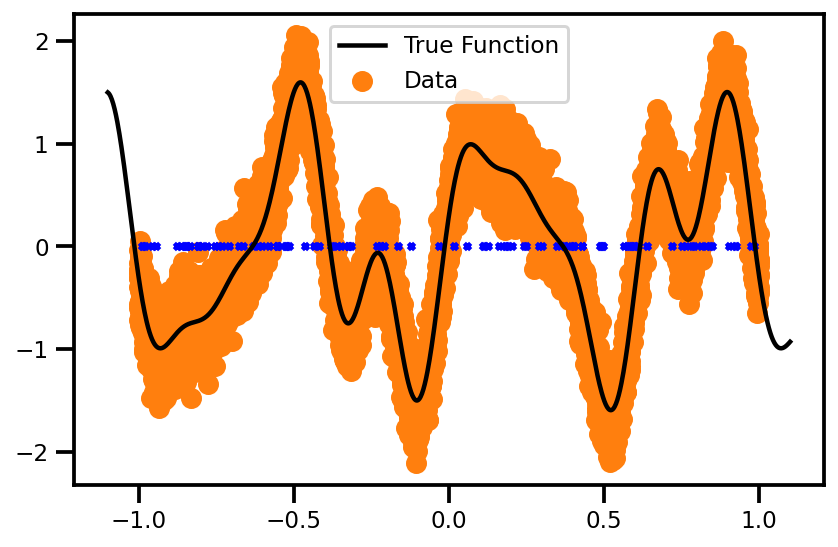

In [10]:
fig, ax = plt.subplots()
ax.scatter(Xtrain, ytrain, color="tab:orange", label="Data")
ax.plot(xtest, ytest, color="black", label="True Function")
ax.scatter(X_u_init, np.zeros(n_inducing), color="blue", marker="x", s=10)
ax.legend()
plt.tight_layout()
plt.show()

#### K-Means Clustering

In [11]:
X_u_init = init_inducing_kmeans(Xtrain, n_inducing, seed=123)

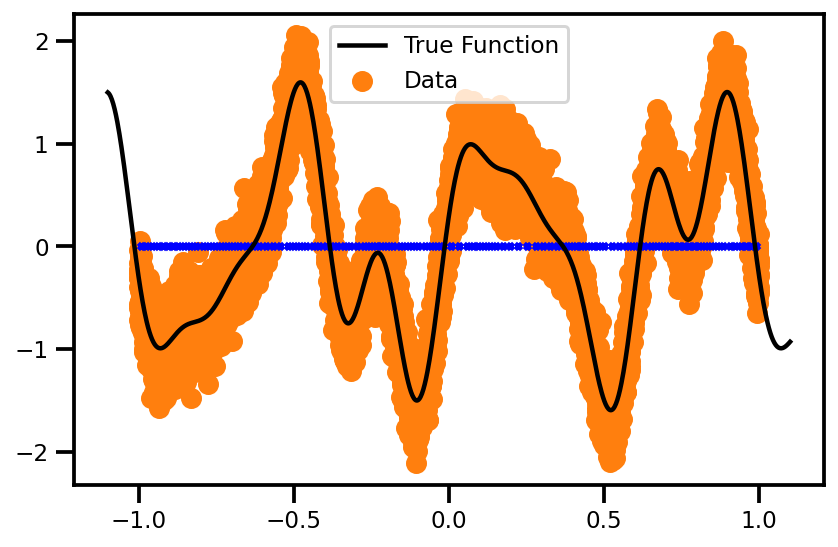

In [12]:
fig, ax = plt.subplots()
ax.scatter(Xtrain, ytrain, color="tab:orange", label="Data")
ax.plot(xtest, ytest, color="black", label="True Function")
ax.scatter(X_u_init, np.zeros(n_inducing), color="blue", marker="x", s=10)
ax.legend()
plt.tight_layout()
plt.show()

In [14]:
from src.sparse import SGPVFE, SGPFITC
from src.means import zero_mean
from chex import Array

jitter = 1e-5


def numpyro_model(X, y):

    #     # Set priors on hyperparameters.
    #     η = numpyro.sample("variance", dist.HalfCauchy(scale=5.0))
    #     ℓ = numpyro.sample("length_scale", dist.Gamma(2.0, 1.0))
    #     σ = numpyro.sample("obs_noise", dist.HalfCauchy(scale=5.0))
    #     x_u = numpyro.sample("x_u", dist.Uniform(-1.0, 1.0), sample_shape=X_u_init.shape)

    x_u = numpyro.param("x_u", init_value=X_u_init)

    # set params and constraints on hyperparams
    η = numpyro.param("variance", init_value=1.0, constraints=dist.constraints.positive)
    ℓ = numpyro.param(
        "length_scale", init_value=0.1, constraints=dist.constraints.positive
    )
    σ = numpyro.param("obs_noise", init_value=0.1, onstraints=dist.constraints.positive)

    # Kernel Function
    rbf_kernel = RBF(variance=η, length_scale=ℓ)

    # GP Model
    gp_model = SGPVFE(
        X=X, X_u=x_u, y=y, mean=zero_mean, kernel=rbf_kernel, obs_noise=σ, jitter=jitter
    )

    # Sample y according SGP
    return gp_model.to_numpyro(y=y)


def empty_guide(X, y):
    pass

In [15]:
with numpyro.handlers.seed(rng_seed=123):
    t = numpyro_model(Xtrain, ytrain)

assert t.shape == Xtrain.shape

## Exact GP - Maximum Marginal Likelihood

In [16]:
from numpyro.infer.autoguide import (
    AutoDelta,
)  # AutoDiagonalNormal, AutoIAFNormal, AutoLaplaceApproximation, AutoMultivariateNormal

In [17]:
# ===================
# Model
# ===================
# GP model

# delta guide - basically deterministic
delta_guide = AutoDelta(numpyro_model)
mll_guide = empty_guide

In [18]:
# reproducibility
rng_key = random.PRNGKey(0)


# Setup
optimizer = numpyro.optim.Adam(step_size=0.005)
# optimizer = numpyro.optim.Minimize()
# optimizer = optax.adamw(learning_rate=0.1)
svi = SVI(numpyro_model, mll_guide, optimizer, loss=Trace_ELBO())
svi_results = svi.run(random.PRNGKey(1), 100, Xtrain, ytrain.T)

100%|██████████| 100/100 [00:12<00:00,  8.31it/s, init loss: -225.8638, avg. loss [96-100]: -1818.6277]


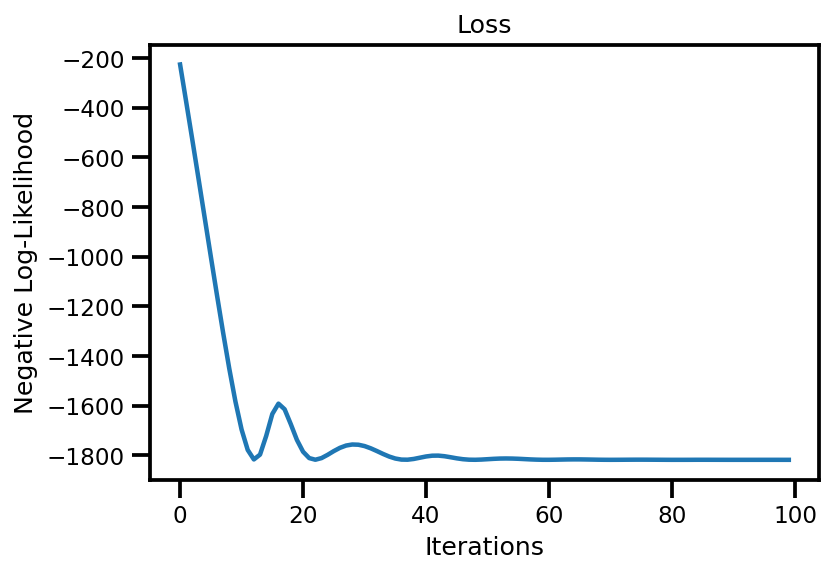

In [19]:
fig, ax = plt.subplots()

ax.plot(svi_results.losses)
ax.set(title="Loss", xlabel="Iterations", ylabel="Negative Log-Likelihood")
plt.show()

### Extracting the Params

In [20]:
from pprint import pprint

# Take them directly
learned_params = svi_results.params
# x_u = learned_params["x_u"]
# learned_params = delta_guide.median(learned_params)
# learned_params["x_u"] = x_u

## Predictions

In [21]:
from src.sparse import SGPPredictive, get_cond_params

sgp_pred = SGPPredictive(**get_cond_params(RBF, learned_params, Xtrain, ytrain))

In [22]:
mu, cov = sgp_pred.predict_f(xtest)

std = jnp.sqrt(jnp.diag(cov.squeeze()))

In [23]:
ci = 1.96
one_stddev = ci * std

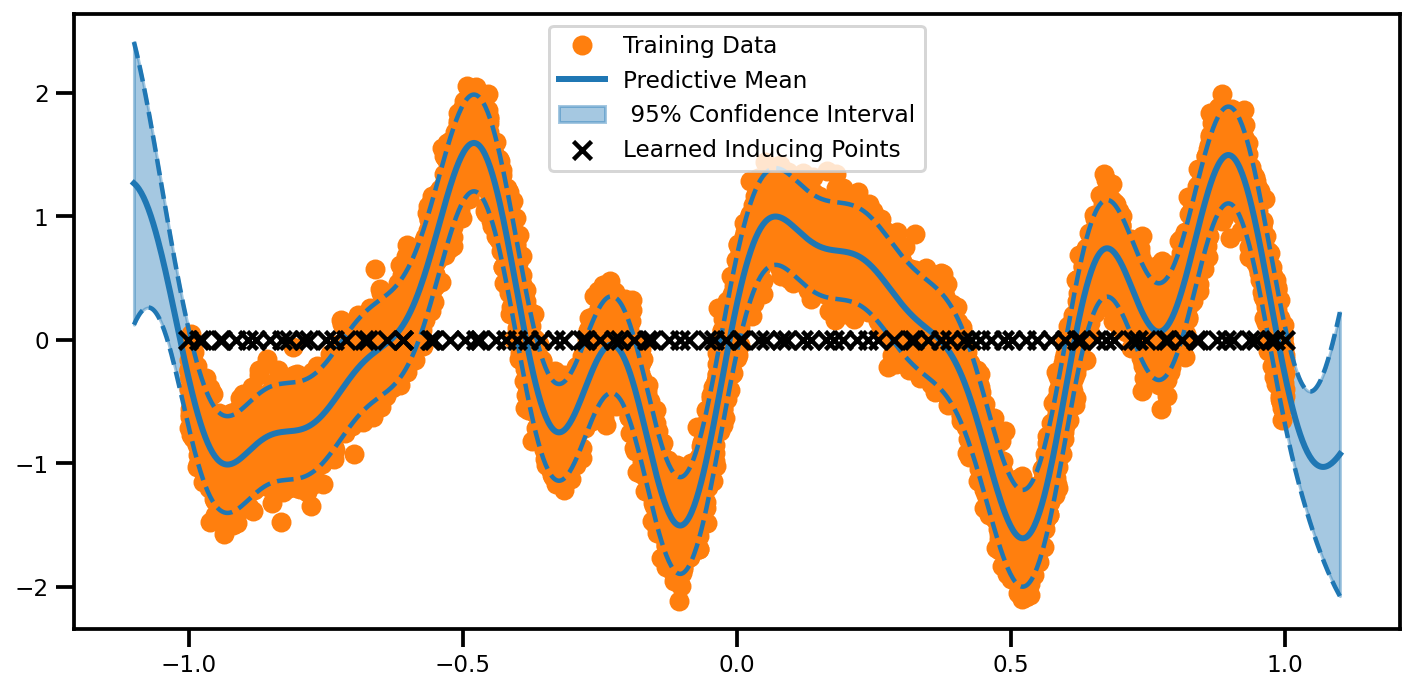

In [28]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(Xtrain, ytrain.squeeze(), "o", color="tab:orange", label="Training Data")
ax.plot(xtest, mu.ravel(), color="tab:blue", linewidth=3, label="Predictive Mean")
ax.fill_between(
    xtest.ravel(),
    mu.ravel() - one_stddev,
    mu.ravel() + one_stddev,
    alpha=0.4,
    color="tab:blue",
    label=f" 95% Confidence Interval",
)
plt.scatter(
    learned_params["x_u"],
    np.zeros_like(learned_params["x_u"]),
    label="Learned Inducing Points",
    color="black",
    marker="x",
    zorder=3,
)
ax.plot(xtest, mu.ravel() - one_stddev, linestyle="--", color="tab:blue")
ax.plot(xtest, mu.ravel() + one_stddev, linestyle="--", color="tab:blue")
plt.tight_layout()
plt.legend()

### Calibration

In [25]:
from uncertainty_toolbox import viz as utviz

#### Training Data

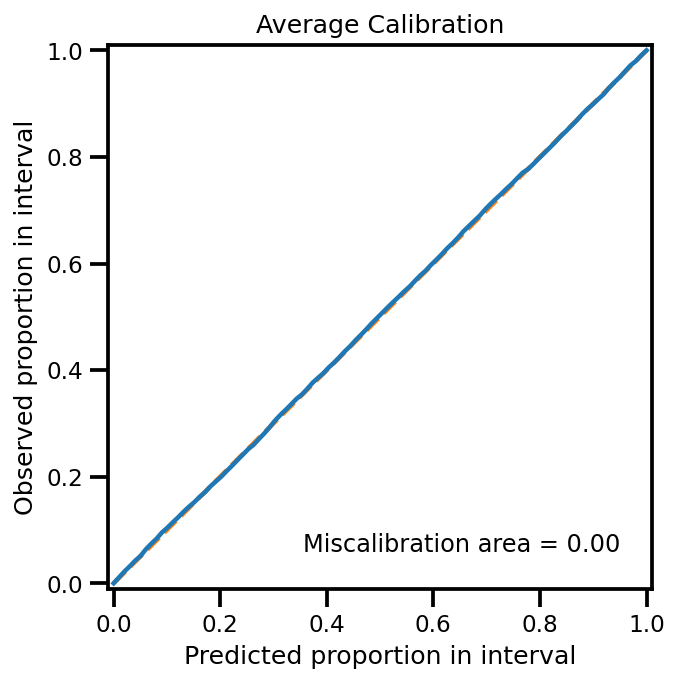

In [26]:
mu, cov = sgp_pred.predict_f(Xtrain)

std = jnp.sqrt(jnp.diag(cov.squeeze()))

utviz.plot_calibration(y_pred=mu.ravel(), y_std=std.ravel(), y_true=ytrain.ravel())

#### Test Data

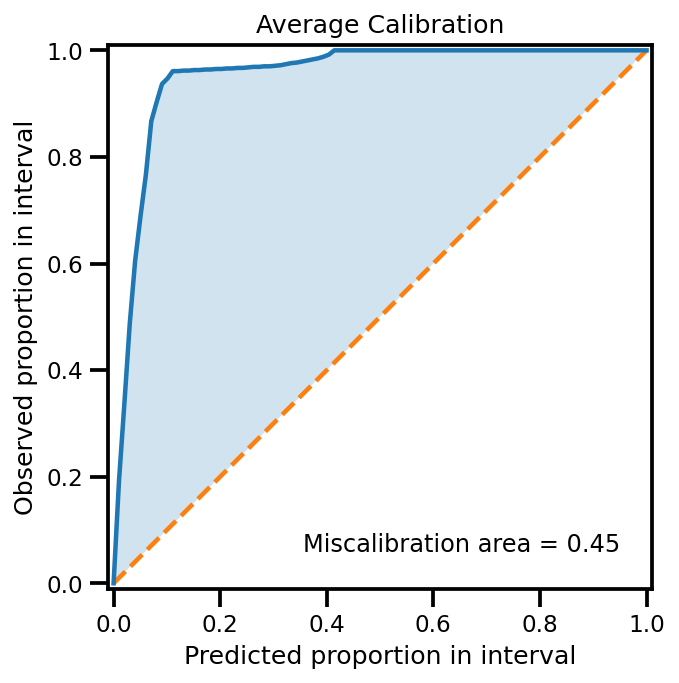

In [27]:
mu, cov = sgp_pred.predict_f(xtest)

std = jnp.sqrt(jnp.diag(cov.squeeze()))

utviz.plot_calibration(y_pred=mu.ravel(), y_std=std.ravel(), y_true=ytest.ravel())